In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import argparse
import glob
import util.io as io
import compressible
import util.plot_tools as plot_tools
from scipy import stats
from scipy.integrate import trapz
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gsp
from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
basename = 'kh_random_outputs/256/kh_random_256'
# basename = 'kh_random_outputs/128/kh_random_128'

In [5]:
files = glob.glob(basename+'_[0-9]*_[1-9][0-9]*.h5')

sim_first = io.read(files[0])
ivars = compressible.Variables(sim_first.cc_data)
myg = sim_first.cc_data.grid
files_size = (len(files), myg.ihi-myg.ilo, myg.jhi-myg.jlo)
all_densities = numpy.zeros(files_size)
for i, f in tqdm(enumerate(files), total=len(files)):
    s = io.read(f)
    gamma = s.cc_data.get_aux("gamma")
    dx = s.cc_data.grid.dx
    dy = s.cc_data.grid.dy
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    all_densities[i, :, :] = q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]

mean_rho = all_densities.mean(axis=0)
var_rho = all_densities.var(axis=0)

  0%|          | 0/513 [00:00<?, ?it/s]/Users/ih3/Documents/github/pyro2/compressible/simulation.py:61: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iu] = U[:, :, ivars.ixmom]/U[:, :, ivars.idens]
/Users/ih3/Documents/github/pyro2/compressible/simulation.py:62: RuntimeWarning: invalid value encountered in true_divide
  q[:, :, ivars.iv] = U[:, :, ivars.iymom]/U[:, :, ivars.idens]
100%|██████████| 513/513 [00:07<00:00, 73.22it/s]


In [6]:
max_density = numpy.max(all_densities)
min_density = numpy.min(all_densities)
d_density = max_density - min_density
support = numpy.linspace(min_density - d_density, max_density + d_density,
                        500)
kdensity = numpy.zeros((len(support), files_size[2]))
for j_y in tqdm(range(files_size[2])):
    densities = numpy.mean(all_densities[:, :, j_y], axis=1)
    bandwidth = 1.06 * densities.std() * densities.size ** (-1 / 5.)
    kernels = []
    for x_i in densities:
       kernel = stats.norm(x_i, bandwidth).pdf(support)
       kernels.append(kernel)
    kdensity[:, j_y] = numpy.sum(kernels, axis=0)
    kdensity[:, j_y] /= trapz(kdensity[:, j_y], support)

100%|██████████| 255/255 [01:31<00:00,  2.98it/s]


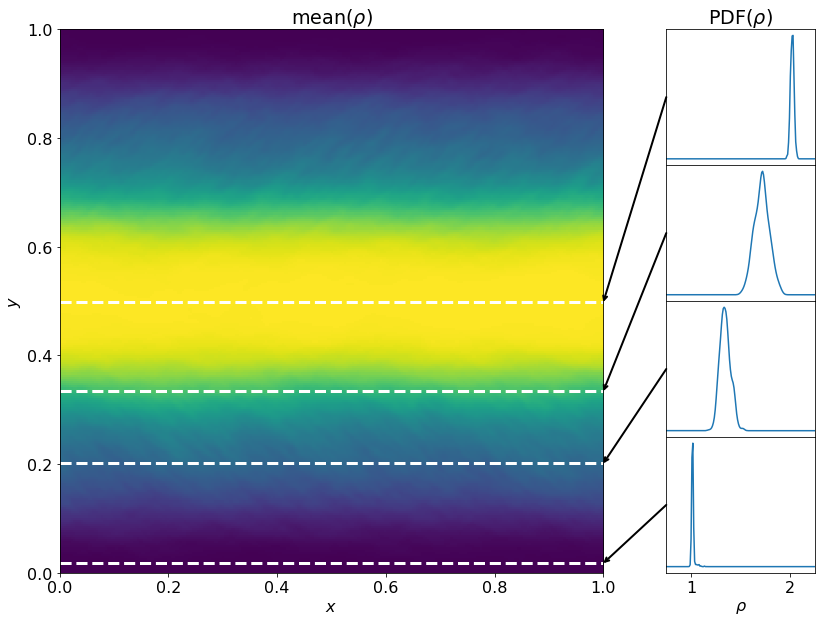

In [7]:
fig = plt.figure(constrained_layout=False, figsize=(14, 10))
widths = [1, 0.25]
heights = [1, 1, 1, 1]
gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                      hspace=0.001, wspace=0.1)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
ax_main = fig.add_subplot(gs[:, 0])
ax_main.imshow(numpy.transpose(mean_rho),
               interpolation="nearest", origin="lower",
               extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
               cmap=s.cm)
ax_main.set_xlabel(r"$x$")
ax_main.set_ylabel(r"$y$")
ax_main.set_title(r"mean($\rho$)")
size_j = mean_rho.shape[1]
j_indexes = [size_j//2, size_j//3, size_j//5, size_j//60]
y_vals = myg.y[myg.jlo:myg.jhi]
for i, j_i in enumerate(j_indexes):
    ax_main.axhline(y_vals[j_i], myg.xmin, myg.xmax, ls='--', lw=3, color='white')
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(support, kdensity[:, j_i])
    ax.set_xlim(min_density, max_density)
    ax.set_xlabel(r"$\rho$")
    ax.set_yticks([])
    ave_kdensity = (min(kdensity[:, j_i])+max(kdensity[:, j_i]))/2
    conn = ConnectionPatch(xyA=(min_density, ave_kdensity),
                           xyB=(myg.xmax, y_vals[j_i]),
                           coordsA='data', coordsB='data',
                           axesA=ax, axesB=ax_main,
                           arrowstyle='->', lw=2)
    ax.add_artist(conn)
    if i==0:
        ax.set_title(r"PDF($\rho$)")

# plt.savefig("var_mean_kde_256.pdf", bbox_inches="tight")
# plt.savefig("var_mean_kde_256.png")
# plt.show()

In [8]:
files = ['kh_random_outputs/256/kh_random_256_1234_0000.h5',
         'kh_random_outputs/512/kh_random_512_1234_0000.h5',
         'kh_random_outputs/1024/kh_random_1024_1234_0000.h5',
         'kh_random_outputs/2048/kh_random_2048_1234_0000.h5']
sizes = [256, 512, 1024, 2048]

densities = []
max_rho = -numpy.inf
min_rho = numpy.inf
for f in files:
    s = io.read(f)
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    densities.append(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho])
    max_rho = max(max_rho, numpy.max(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi,
                                       ivars.irho]))
    min_rho = min(min_rho, numpy.min(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi,
                                       ivars.irho]))

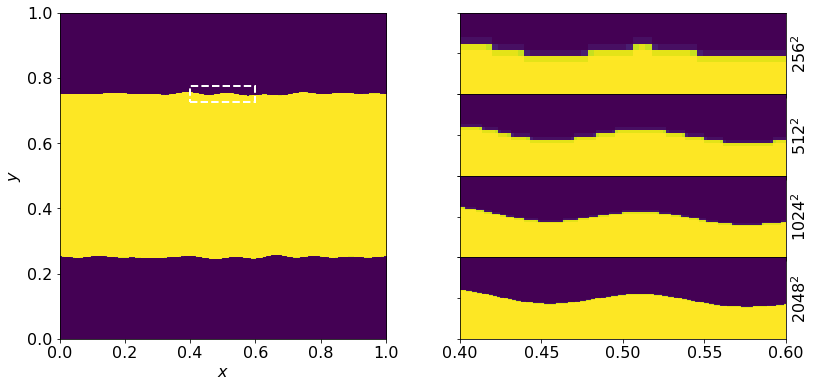

In [9]:
fig = plt.figure(constrained_layout=False, figsize=(14, 6))
widths = [1, 1]
heights = [1, 1, 1, 1]
gs = fig.add_gridspec(4, 2, width_ratios=widths, height_ratios=heights,
                      hspace=0.001, wspace=0.05)
ax_main = fig.add_subplot(gs[:, 0])
ax_main.imshow(numpy.transpose(densities[-1]),
               interpolation="nearest", origin="lower",
               extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
               cmap=s.cm)
ax_main.set_xlabel(r"$x$")
ax_main.set_ylabel(r"$y$")
zoom_axes = []
zoom_width = 0.2
extents = [myg.xmin + (0.5-zoom_width/2)*(myg.xmax-myg.xmin),
           myg.xmin + (0.5+zoom_width/2)*(myg.xmax-myg.xmin),
           myg.xmin + (0.75-zoom_width/8)*(myg.ymax-myg.ymin),
           myg.xmin + (0.75+zoom_width/8)*(myg.ymax-myg.ymin)]

rect = Rectangle((extents[0], extents[2]), extents[1]-extents[0], extents[3]-extents[2],
                 linewidth=2, linestyle='--', edgecolor='w', facecolor='none')
ax_main.add_patch(rect)

for i in range(4):
    iextents=[int(sizes[i]*e) for e in extents]
    zoom_axes.append(fig.add_subplot(gs[i, 1]))
    zoom_axes[i].imshow(numpy.transpose(densities[i][iextents[0]:iextents[1], iextents[2]:iextents[3]]),
                        interpolation="nearest", origin="lower",
                        extent=extents,
                        cmap=s.cm)
    # zoom_axes[i].set_axis_off()
    if i != 3:
        zoom_axes[i].set_xticklabels([])
    zoom_axes[i].set_yticklabels([])
    zoom_axes[i].set_ylabel(fr"{sizes[i]}${{}}^2$")
    zoom_axes[i].yaxis.set_label_position("right")

# plt.savefig("kh_plot_id.pdf", bbox_inches="tight")
# plt.savefig("kh_plot_id.png")
# plt.show()

In [10]:
resolutions = [128, 256, 512]
mean_rhos = []
var_rhos = []
mean_vorticities = []
var_vorticities = []
mean_rho_lims = [numpy.inf, -numpy.inf]
var_rho_lims = [numpy.inf, -numpy.inf]
mean_vorticity_lims = [numpy.inf, -numpy.inf]
var_vorticity_lims = [numpy.inf, -numpy.inf]
for resolution in resolutions:
    basename = f'kh_random_outputs/{resolution}/kh_random_{resolution}'

    files = glob.glob(basename+'_[0-9]*_[1-9][0-9]*.h5')

    sim_first = io.read(files[0])
    ivars = compressible.Variables(sim_first.cc_data)
    myg = sim_first.cc_data.grid
    files_size = (len(files), myg.ihi-myg.ilo, myg.jhi-myg.jlo)
    all_densities = numpy.zeros(files_size)
    all_vorticities = numpy.zeros_like(all_densities)
    for i, f in tqdm(enumerate(files), total=len(files)):
        s = io.read(f)
        gamma = s.cc_data.get_aux("gamma")
        dx = s.cc_data.grid.dx
        dy = s.cc_data.grid.dy
        q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                      s.cc_data.grid)
        all_densities[i, :, :] = q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]

        u = q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.iu]
        v = q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.iv]
        dvx_up = (v[2:, 1:-1] - v[1:-1, 1:-1]) / dx
        dvx_do = (v[1:-1, 1:-1] - v[:-2, 1:-1]) / dx
        dvx = numpy.where(dvx_up * dvx_do <= 0,
                          numpy.zeros_like(dvx_up),
                          numpy.where(numpy.abs(dvx_up) < numpy.abs(dvx_do),
                                      dvx_up, dvx_do))
        duy_up = (u[1:-1, 2:] - u[1:-1, 1:-1]) / dy
        duy_do = (u[1:-1, 1:-1] - u[1:-1, :-2]) / dy
        duy = numpy.where(duy_up * duy_do <= 0,
                          numpy.zeros_like(duy_up),
                          numpy.where(numpy.abs(duy_up) < numpy.abs(duy_do),
                                      duy_up, duy_do))
        all_vorticities[i, 1:-1, 1:-1] = dvx - duy

    mean_rho = all_densities.mean(axis=0)
    var_rho = all_densities.var(axis=0)
    mean_vorticity = all_vorticities.mean(axis=0)
    var_vorticity = all_vorticities.var(axis=0)
    mean_rhos.append(mean_rho)
    var_rhos.append(var_rho)
    mean_vorticities.append(mean_vorticity)
    var_vorticities.append(var_vorticity)
    mean_rho_lims[0] = min(mean_rho_lims[0], numpy.min(mean_rho))
    mean_rho_lims[1] = max(mean_rho_lims[1], numpy.max(mean_rho))
    var_rho_lims[0] = min(var_rho_lims[0], numpy.min(var_rho))
    var_rho_lims[1] = max(var_rho_lims[1], numpy.max(var_rho))
    mean_vorticity_lims[0] = min(mean_vorticity_lims[0], numpy.min(mean_vorticity))
    mean_vorticity_lims[1] = max(mean_vorticity_lims[1], numpy.max(mean_vorticity))
    var_vorticity_lims[0] = min(var_vorticity_lims[0], numpy.min(var_vorticity))
    var_vorticity_lims[1] = max(var_vorticity_lims[1], numpy.max(var_vorticity))

100%|██████████| 101/101 [00:07<00:00, 11.70it/s]


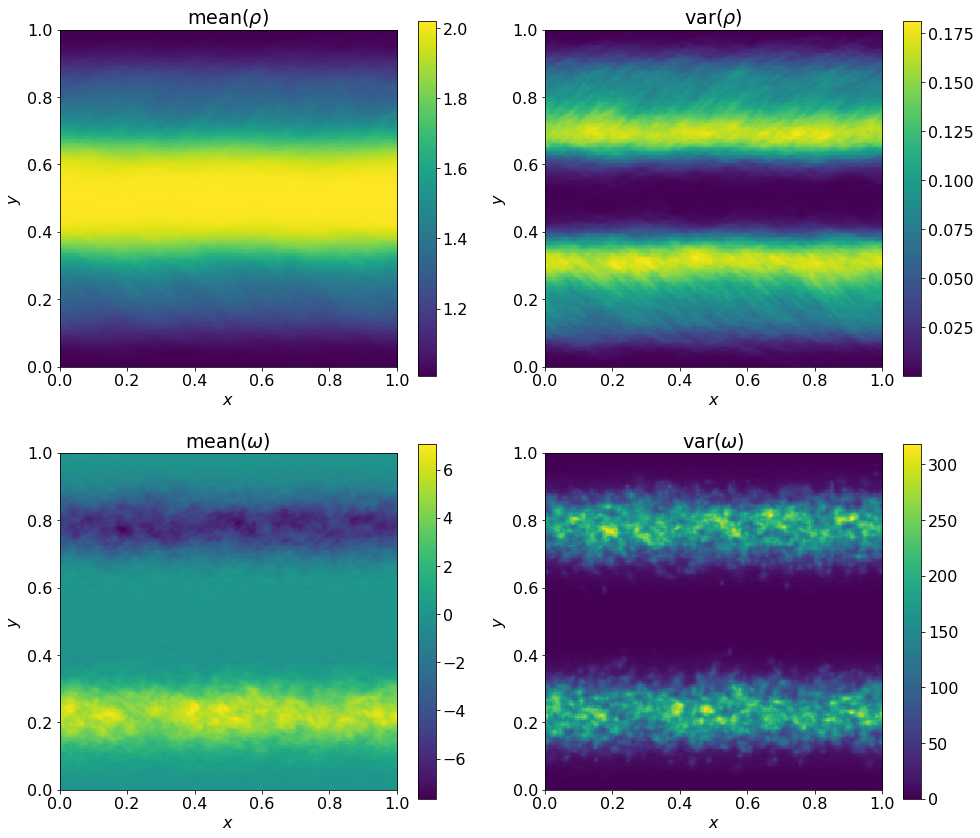

In [11]:
fields = [mean_rhos[1], var_rhos[1], mean_vorticities[1], var_vorticities[1]]
field_names = [r"mean($\rho$)", r"var($\rho$)",
               r"mean($\omega$)", r"var($\omega$)"]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for v, name, ax in zip(fields, field_names, axes.flat):
    im = ax.imshow(numpy.transpose(v),
                   interpolation="nearest", origin="lower",
                   extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
                   cmap=s.cm)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(name)
    cbar = fig.colorbar(im, ax=ax)
fig.tight_layout()

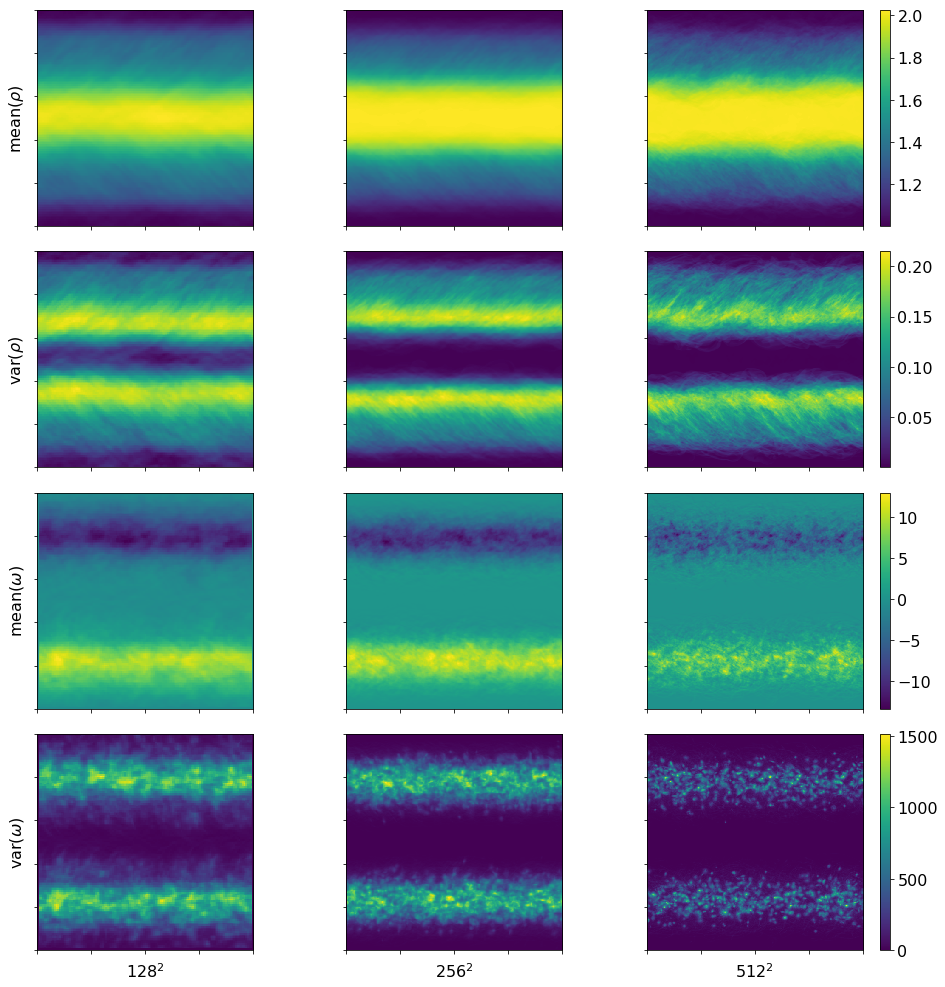

In [12]:
fields = [mean_rhos, var_rhos, mean_vorticities, var_vorticities]
field_names = [r"mean($\rho$)", r"var($\rho$)",
               r"mean($\omega$)", r"var($\omega$)"]
fig, axes = plt.subplots(4, 3, figsize=(14, 14))

for row, (field, name) in enumerate(zip(fields, field_names)):
    for col, resolution in enumerate(resolutions):
        ax = axes[row, col]
        im = ax.imshow(numpy.transpose(field[col]),
                       interpolation="nearest", origin="lower",
                       extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
                       cmap=s.cm)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        if row == 3:
            ax.set_xlabel(rf"{resolution}${{}}^2$")
        if col == 0:
            ax.set_ylabel(name)
        if col == 2:
            cbar = fig.colorbar(im, ax=ax)

fig.tight_layout()
# plt.subplots_adjust(hspace=0.05, wspace=0.01)

In [13]:
realizations = list(range(1,129))

densities = []
max_rho = -numpy.inf
min_rho = numpy.inf
for r in realizations:
    f = glob.glob(f'kh_random_outputs/256/kh_random_256_{r}_[1-9]*.h5')
    assert len(f)==1
    s = io.read(f[0])
    ivars = compressible.Variables(s.cc_data)
    myg = s.cc_data.grid
    gamma = s.cc_data.get_aux("gamma")
    q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
                                  s.cc_data.grid)
    densities.append(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho])
    max_rho = max(max_rho, numpy.max(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))
    min_rho = min(min_rho, numpy.min(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))

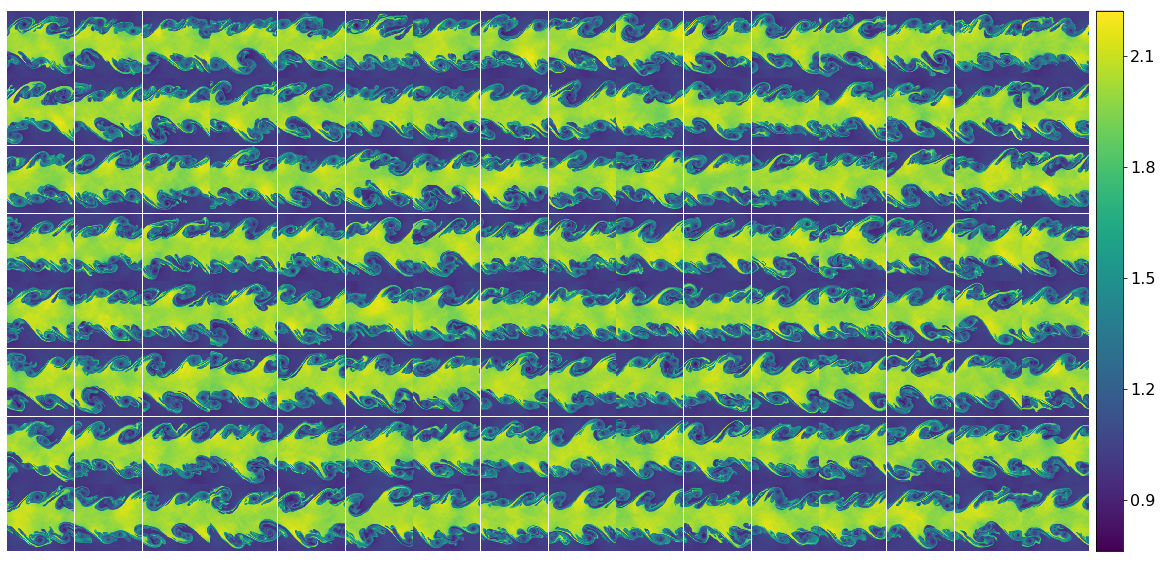

In [14]:
fig = plt.figure(figsize=(20, 10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2**3, 2**4),
                axes_pad=0.01,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for ax, rho in zip(grid, densities):
    ax.set_axis_off()
    im = ax.imshow(numpy.transpose(rho),
                   interpolation="nearest", origin="lower",
                   extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
                   vmin = min_rho, vmax=max_rho,
                   cmap=s.cm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar = ax.cax.colorbar(im)

In [15]:
# realizations = list(range(1,513))

# densities = []
# max_rho = -numpy.inf
# min_rho = numpy.inf
# for r in realizations:
#     f = glob.glob(f'kh_random_outputs/256/kh_random_256_{r}_[1-9]*.h5')
#     assert len(f)==1
#     s = io.read(f[0])
#     ivars = compressible.Variables(s.cc_data)
#     myg = s.cc_data.grid
#     gamma = s.cc_data.get_aux("gamma")
#     q = compressible.cons_to_prim(s.cc_data.data, gamma, ivars,
#                                   s.cc_data.grid)
#     densities.append(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho])
#     max_rho = max(max_rho, numpy.max(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))
#     min_rho = min(min_rho, numpy.min(q[myg.ilo:myg.ihi, myg.jlo:myg.jhi, ivars.irho]))

In [16]:
# fig = plt.figure(figsize=(20, 10))

# grid = AxesGrid(fig, 111,
#                 nrows_ncols=(2**4, 2**5),
#                 axes_pad=0.01,
#                 cbar_mode='single',
#                 cbar_location='right',
#                 cbar_pad=0.1
#                 )

# for ax, rho in zip(grid, densities):
#     ax.set_axis_off()
#     im = ax.imshow(numpy.transpose(rho),
#                    interpolation="nearest", origin="lower",
#                    extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
#                    vmin = min_rho, vmax=max_rho,
#                    cmap=s.cm)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# cbar = ax.cax.colorbar(im)